In [1]:
import sys
sys.path.append('../src')  # Add the src directory

from utils.file_handler import BetfairFileHandler
from models import GRUModel, LSTMModel, TransformerModel, BiLSTMModel, train_model, plot_loss_curves, prepare_dataloaders
from models.model_utils import save_model, load_model, process_multiple_markets, normalize_data
from preprocessing.feature_engineering import calculate_macd, calculate_roc, calculate_moving_average
from preprocessing.data_preprocessor import preprocess_market_data, drop_na_rows, remove_outliers
from models.evaluation import plot_predictions, plot_residuals, plot_residual_histogram
from strategy.base_strategy import BaseFlatBetting
from strategy.simulation import run_sim_process

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import betfairutil
import seaborn as sns
import os
from torch.optim.lr_scheduler import OneCycleLR

/Users/charaka/opt/anaconda3/envs/digital_finance/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
ROOT_DIR = "/Users/charaka/Desktop/Projects/football-lstm-betting"

In [3]:
input_directory = os.path.join(ROOT_DIR, "data/raw/2023/Jan")
output_directory = os.path.join(ROOT_DIR, "data/processed/")

# handler = BetfairFileHandler()
# handler.extract_files(input_directory, output_directory, should_restrict_to_inplay=True, _format=betfairutil.DataFrameFormatEnum.LAST_PRICE_TRADED)

In [4]:
input_directory, output_directory

('/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/2023/Jan',
 '/Users/charaka/Desktop/Projects/football-lstm-betting/data/processed/')

In [5]:
"/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/2023/Jan/1/31954039"

'/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/2023/Jan/1/31954039'

In [6]:
data_folder = "/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/2023/Jan/1/31954039"
data_files = os.listdir(data_folder,)
data = [f'{data_folder}/{path}' for path in data_files]


In [7]:
data = ['/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/2023/Jan/1/31954039/1.207325009']

In [8]:
from utils.stratergy_logging_control import BacktestLoggingControl
from strategy.base_strategy import BaseFlatBetting
from flumine import FlumineSimulation, BaseStrategy, utils, clients

In [9]:
strategy = BaseFlatBetting(
    market_filter={
        "markets": data,  
        'market_types':['MATCH_ODDS'],
        "listener_kwargs": {"inplay": False, "seconds_to_start": 80},  
        },
    max_order_exposure=1000,
    max_selection_exposure=1000,
    max_trade_count=1000,
)

client = clients.SimulatedClient()
framework = FlumineSimulation(client=client)

# Run our strategy on the simulated market
framework.add_strategy(strategy)
framework.add_logging_control(
    BacktestLoggingControl()
)
framework.run()

In [16]:
_process_jobs[0].result()

TypeError: cannot pickle '_thread.lock' object

In [15]:
from concurrent import futures
import dill
futures.process.DEFAULT_PICKLER = dill

processes = os.cpu_count()
_process_jobs = []

with futures.ProcessPoolExecutor(max_workers=processes) as p:
    _process_jobs.append(
        p.submit(
            run_sim_process,
            strategy=strategy,
        )
    )

for job in futures.as_completed(_process_jobs):
    job.result()  # wait for result

KeyboardInterrupt: 

In [36]:
SEQ_LENGTH = 5
df = data_processing.load_data("../data/raw/sample_1.json")

NameError: name 'data_processing' is not defined

In [44]:
df["timestamp"].max() - df["timestamp"].min()

Timedelta('0 days 02:09:15.184000')

In [45]:
df

,timestamp,runner_id,odds,amount
14,2023-01-26 17:46:46.096,24931403,2.36,2858.96
33,2023-01-26 17:46:48.686,58805,3.50,2135.70
38,2023-01-26 17:46:50.766,58805,3.50,2137.74
50,2023-01-26 17:46:51.692,58805,3.50,2138.54
55,2023-01-26 17:46:53.773,58805,3.50,2141.92
...,...,...,...,...
52974,2023-01-26 19:53:42.399,8942269,1.03,1109.72
52978,2023-01-26 19:53:42.556,8942269,1.03,1460.79
53000,2023-01-26 19:56:01.280,24931403,2.50,0.00
52999,2023-01-26 19:56:01.280,8942269,6.40,0.00


In [46]:
df["runner_id"].value_counts()

8942269     3944
58805       3466
24931403    3381
Name: runner_id, dtype: int64

In [47]:
df = df[df.runner_id == 8942269]

In [48]:
# Data Cleaning: Handle missing values using forward-filling
df.fillna(method='ffill', inplace=True)

# Uniform Timestamps: Resampling to have consistent 1-minute intervals
df.set_index('timestamp', inplace=True)
resampled_df = df.resample('0.25T').ffill()
resampled_df['ma_odds'] = resampled_df['odds'].rolling(window=5).mean()
resampled_df['momentum_odds'] = resampled_df['odds'] - resampled_df['odds'].shift(5)

/var/folders/7r/wl3x6jwx2912f_7n3sv274kh0000gn/T/ipykernel_94958/2272954919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(method='ffill', inplace=True)


In [49]:
resampled_df

,runner_id,odds,amount,ma_odds,momentum_odds
timestamp,,,,,
2023-01-26 17:47:00,NaN,NaN,NaN,NaN,NaN
2023-01-26 17:47:15,8942269.0,3.45,643.74,NaN,NaN
2023-01-26 17:47:30,8942269.0,3.50,3922.58,NaN,NaN
2023-01-26 17:47:45,8942269.0,3.50,3986.64,NaN,NaN
2023-01-26 17:48:00,8942269.0,3.50,4087.17,NaN,NaN
...,...,...,...,...,...
2023-01-26 19:55:00,8942269.0,1.03,1460.79,1.03,0.0
2023-01-26 19:55:15,8942269.0,1.03,1460.79,1.03,0.0
2023-01-26 19:55:30,8942269.0,1.03,1460.79,1.03,0.0


<Axes: xlabel='timestamp'>

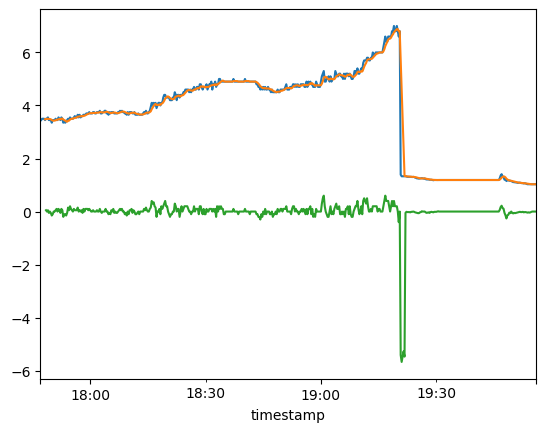

In [50]:
resampled_df["odds"].plot()
resampled_df["ma_odds"].plot()
resampled_df["momentum_odds"].plot()

In [51]:
resampled_df.dropna(inplace=True)

/var/folders/7r/wl3x6jwx2912f_7n3sv274kh0000gn/T/ipykernel_94958/1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [52]:
# Convert the combined dataframe to sequences
def create_combined_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length].values[:data.shape[1] // 2]  # we only predict odds for the next step
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Generate sequences
X_combined, y_combined = create_combined_sequences(df, SEQ_LENGTH)


In [70]:
i = 0

In [73]:
combined_df.iloc[i:(i + 6)]

prob                        volume            \
runner_id                58805     8942269   24931403  58805     8942269    
timestamp                                                                   
2023-01-22 12:20:15.825  0.260728  0.264114  0.475158  0.003989  0.000444   
2023-01-22 12:45:59.153  0.248226  0.287799  0.463975  0.000018  0.000788   
2023-01-22 13:21:45.986  0.263059  0.282121  0.454821  0.001433  0.000788   
2023-01-22 19:06:44.546  0.263059  0.282121  0.454821  0.001432  0.000788   
2023-01-22 20:04:32.315  0.263059  0.282121  0.454821  0.001432  0.000788   
2023-01-22 20:40:19.364  0.268170  0.268170  0.463659  0.001432  0.000964   

                                   
runner_id                24931403  
timestamp                          
2023-01-22 12:20:15.825  0.003204  
2023-01-22 12:45:59.153  0.003234  
2023-01-22 13:21:45.986  0.003234  
2023-01-22 19:06:44.546  0.003234  
2023-01-22 20:04:32.315  0.003234  
2023-01-22 20:40:19.364  0.003234

In [80]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Define LSTM model
model = Sequential()

# Input Layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# LSTM Layers with Dropout
model.add(LSTM(units=30, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=20, activation='relu'))

# Output Layer
model.add(Dense(units=X_train.shape[2]))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

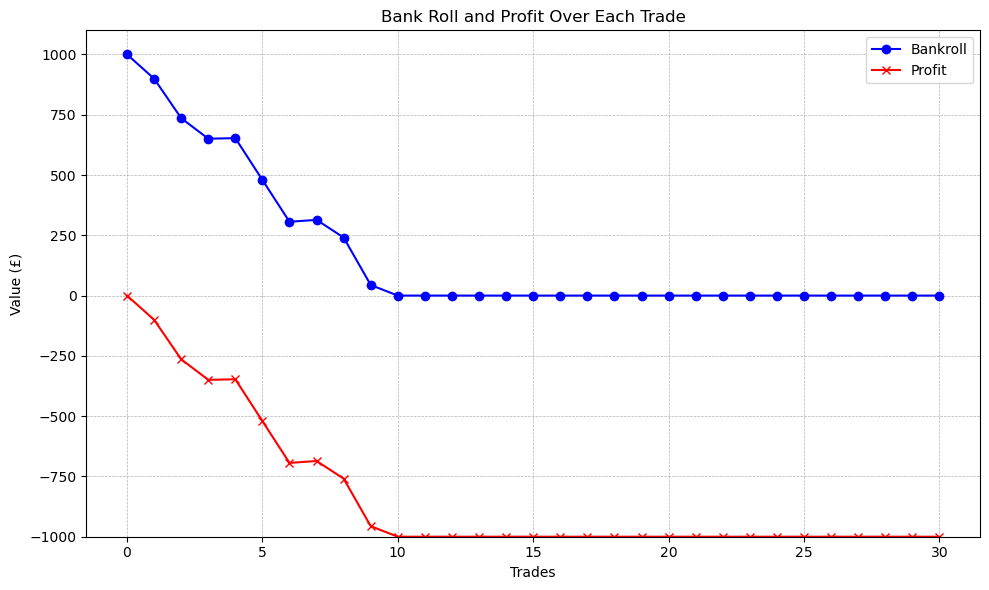

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Initial settings
bankroll = 1000
trades = 30
noise_scale = 100

# Generate the bankroll values
values = [bankroll]
for i in range(trades):
    if i < trades / 2:
        # Faster decay in the first half
        delta = np.random.normal(-150, noise_scale)
    else:
        # Slower decay in the second half
        delta = np.random.normal(-30, 10)
    next_value = values[-1] + delta
    values.append(max(0, next_value))  # Ensure bankroll doesn't go below 0

# Plot the bankroll evolution
profits = [values[i] - values[i-1] for i in range(1, len(values))]

# Cumulative sum of profits for plotting
cumulative_profits = np.cumsum(profits)
cumulative_profits = np.insert(cumulative_profits, 0, 0)  # Insert a 0 at the beginning

# Plot the bankroll and profit evolution
plt.figure(figsize=(10, 6))
plt.plot(values, marker='o', linestyle='-', color='b', label='Bankroll')
plt.plot(cumulative_profits, marker='x', linestyle='-', color='r', label='Profit')
plt.title('Bank Roll and Profit Over Each Trade')
plt.xlabel('Trades')
plt.ylabel('Value (£)')
plt.ylim(-1000, 1100)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()
